In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna  # for hyperparameter tuning
from scipy.signal import butter, filtfilt
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error, mean_squared_error

In [34]:
panasonic_train_norm = pd.read_csv('INSERT DATA PATH')
panasonic_test_norm = pd.read_csv('INSERT DATA PATH')
train_features = panasonic_train_norm[['Voltage', 'Current', 'Temperature']]  
test_features = panasonic_test_norm[['Voltage', 'Current', 'Temperature']]    
train_labels = panasonic_train_norm['Capacity']  
test_labels = panasonic_test_norm['Capacity']

In [35]:
train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.float32).view(-1, 1)

In [36]:
FEATURE_COLS = ['Voltage', 'Current', 'Temperature']
# LABEL_COL = 'Capacity'
LABEL_COL = 'SOC'
BATCH_SIZE = 32  
EPOCHS = 500  
INPUT_WINDOW = 200
FORECAST_WINDOW = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
def create_dataset(df, labels, input_window=200, forecast_window=10):
    X, y = [], []
    for i in range(len(df) - input_window - forecast_window + 1):
        input_feature = df.iloc[i:i + input_window].values
        target = labels.iloc[i + input_window:i + input_window + forecast_window].values     
        X.append(input_feature)
        y.append(target)  
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [38]:
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_length=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_length = forecast_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, forecast_length)
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # x shape: [batch_size, input_window, input_features]
        out, _ = self.lstm(x)
        # Use the last hidden state to predict forecast
        out = self.fc(out[:, -1, :]) 
        if self.activation_fn is not None:
            out = self.activation_fn(out) 
        return out

In [39]:
# When creating datasets
input_window = INPUT_WINDOW
forecast_window = FORECAST_WINDOW
X_train, y_train = create_dataset(train_features, train_labels, input_window, forecast_window)
X_test, y_test = create_dataset(test_features, test_labels, input_window, forecast_window)

# Modify the model instantiation
model = SoCLSTM(
    input_size=len(FEATURE_COLS), 
    hidden_size=32,  
    num_layers=1,    
    forecast_length=forecast_window
).to(device)

# Modify loss calculation in training
def train_model(model, train_loader, val_loader, optimizer, criterion, mae_fn, num_epochs):
    history = {'train_rmse': [], 'val_rmse': [], 'train_mae': [], 'val_mae': []}
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_mae = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_mae += mae_fn(y_pred, y_batch).item()
            train_rmse = np.sqrt(train_loss / len(train_loader))  # RMSE for training
        train_mae = train_mae / len(train_loader)  # MAE for training
        history['train_rmse'].append(train_rmse)
        history['train_mae'].append(train_mae)

        # Validation
        val_rmse, val_mae = validate_model(model, val_loader, criterion, mae_fn)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        print(f"Epoch {epoch+1}/{num_epochs}: Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")
    return history

def validate_model(model, val_loader, criterion, mae_fn):
    model.eval()
    val_loss, val_mae = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
                val_mae +=  mae_fn(y_pred, y_batch).item()
                
    return (np.sqrt(val_loss / len(val_loader))), (val_mae / len(val_loader)) 

In [40]:
X_train, y_train = create_dataset(train_features, train_labels,input_window=input_window, forecast_window=forecast_window)
X_test, y_test = create_dataset(test_features, test_labels, input_window=input_window, forecast_window=forecast_window)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

C:\Users\a103720\AppData\Local\Temp\ipykernel_32904\457146497.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
C:\Users\a103720\AppData\Local\Temp\ipykernel_32904\457146497.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
C:\Users\a103720\AppData\Local\Temp\ipykernel_32904\457146497.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
C:\Users\a103720\AppData

In [41]:
# Training with best hyparameters
hidden_size = 32
num_layers = 1
activation_fn = activation_fn = getattr(nn, 'Tanh')
EPOCHS = 500
min_delta = 0.001  # Minimum improvement threshold for early stopping
patience = 10      # Number of epochs to wait before stopping
best_val_rmse = float('inf')  # Initialize best validation RMSE as infinity
patience_counter = 0 
LEARNING_RATE =  0.001

# Train the final model with the best hyperparameters
model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.MSELoss()
mae_fn = torch.nn.L1Loss()

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train_split, y_train_split,), shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(TensorDataset(X_val_split, y_val_split), shuffle=False, batch_size=BATCH_SIZE)

history = train_model(model, train_loader, val_loader, optimizer, criterion, mae_fn, EPOCHS)  #Though it has returned val_loss and val_mae, but I am interested in all history which is appended in place in train_model function

# Save the model
model_path = "saved_models/soc_lstm_tuned_retrained_10In_10Out.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

Epoch 1/500: Train RMSE: 0.3011, Train MAE: 0.2602, Val RMSE: 0.2995, Val MAE: 0.2592
Epoch 2/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2997, Val MAE: 0.2593
Epoch 3/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2995, Val MAE: 0.2592
Epoch 4/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2993, Val MAE: 0.2591
Epoch 5/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2997, Val MAE: 0.2594
Epoch 6/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2995, Val MAE: 0.2592
Epoch 7/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2998, Val MAE: 0.2594
Epoch 8/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2995, Val MAE: 0.2593
Epoch 9/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2994, Val MAE: 0.2592
Epoch 10/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2996, Val MAE: 0.2593
Epoch 11/500: Train RMSE: 0.2997, Train MAE: 0.2593, Val RMSE: 0.2997, Val MAE: 0.2594
Epoch 12/500: Train RMSE: 0.2997, Train MAE: 0.2593,

C:\Users\a103720\AppData\Local\Temp\ipykernel_32904\3670552990.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

Test RMSE: 0.412797
Test MAE: 0.338679


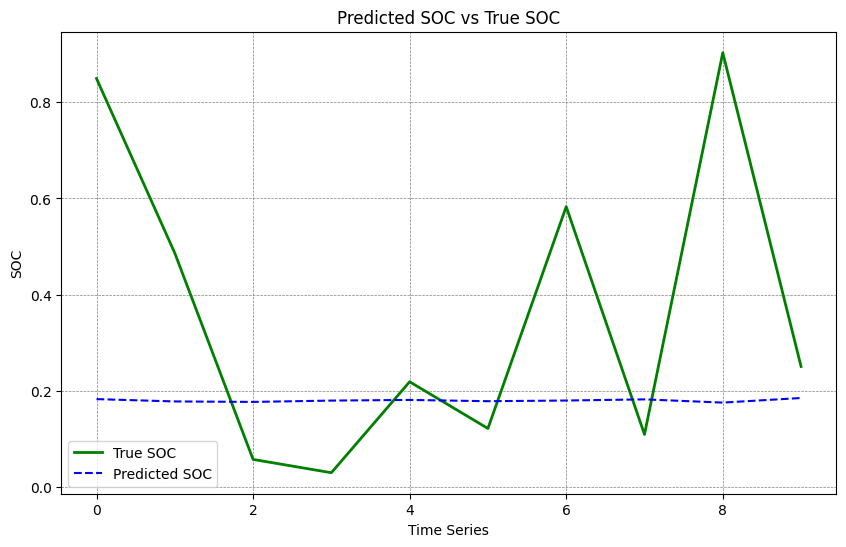

In [42]:
model_path = "saved_models/soc_lstm_tuned_retrained_10In_10Out.pth"
best_hyperparameters = {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.0001, 'activation_fn': 'ReLU'} #original stored in best_hyperparams
activation_functions = {
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid()
}

def load_model(model_path, input_size, hidden_size, num_layers, activation_fn):
    activation_fn = activation_functions.get(activation_fn, nn.Tanh())  # default to Tanh if not found
    model = SoCLSTM(input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS), best_hyperparameters['hidden_size'], 
    best_hyperparameters['num_layers'], 
    best_hyperparameters['activation_fn'])

def test_model(model,X_test_tensor, y_test_tensor, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        test_predictions = outputs.cpu().tolist()
        test_labels = y_test_tensor.cpu().tolist()

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, X_test_tensor, y_test_tensor, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

# Calculate MSE and MAE
mse = np.sqrt(mean_squared_error(test_labels_np, test_predictions_np))
mae = mean_absolute_error(test_labels_np, test_predictions_np)
print(f"Test RMSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")


plt.figure(figsize=(10, 6))
plt.plot(test_labels_np[100], label="True SOC", color="green", linewidth=2)  # Black line for true values
plt.plot( test_predictions_np[100], label="Predicted SOC", color="blue", linestyle="--")  # Blue line for predictions
plt.xlabel('Time Series')
plt.ylabel('SOC')
plt.title('Predicted SOC vs True SOC')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### Saving Results

In [43]:
df = pd.DataFrame({
    'Predictions': [list(pred) for pred in test_predictions_np],
    'Labels': [list(label) for label in test_labels_np]           
})
df.to_csv('Results/test_predictions_labels_LSTM_multistep.csv', index=False)